In [1]:
import sys,os,time
import pandas as pd
import numpy as np
from numba import jit
import numba as nb
from tqdm.notebook import tqdm

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)
import pylab  as py
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

#--torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
torch.set_default_tensor_type(torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor)
dtype = torch.float64

/opt/conda/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
ls /w/jam-sciwork24/apps/lhapdf_tables

ABMP16_3_nlo/                  JAM20-SIDIS_FF_kaon_nlo/
ABMP16_3_nlo.tar               JAM20-SIDIS_FF_pion_nlo/
ABMP16_3_nlo.tar.gz            JAM20-SIDIS_PDF_proton_nlo/
ABMP16als116_5_nnlo.tar.gz     JAM20PionPDFnlo/
ATLAS-epWZ16-EIG/              JAM20SIDIS/
ATLAS-epWZ16-EIG.tar           JAM22ffpion/
CJ12max/                       JAM22pdf/
CJ12max.tar.gz                 JAM22ppdf/
CJ12mid/                       MAPFF10NLOPIp/
CJ12mid.tar.gz                 MAPFF10NLOPIp.tar.gz
CJ12min/                       MMHT2014nlo68cl/
CJ12min.tar.gz                 MMHT2014nlo68cl.tar
CJ15nlo/                       MMHT2014nlo68cl.tar.gz
CJ15nlo.tar.gz                 NNFF10_KAp_nlo/
CSKK_nnlo_EIG/                 NNFF10_KAp_nlo.tar
CSKK_nnlo_EIG.tar              NNFF10_PIp_nlo/
CSKK_nnlo_EIG.tar.gz           NNFF10_PIp_nlo.tar
CT14nlo/                       NNPDF23_lo_as_0130_qed.tar.gz
CT14nlo.tar                    NNPDF30_nlo_as_0118/
CT14nlo.tar.gz                 NNPDF30_nlo_as_0118.ta

In [3]:
import lhapdf
# path="/w/jam-sciwork24/apps/lhapdf_tables:/w/jam-sciwork24/share/replicas"
path="/w/jam-sciwork24/dadamiak/ePump/:/w/jam-sciwork24/share/replicas"
os.environ["LHAPDF_DATA_PATH"] = path
# NNPDF=lhapdf.mkPDFs("NNPDFpol20_nnlo_as_01180_mhou")
CT = lhapdf.getPDFSet("CT18NNLO")
# NNPDF=lhapdf.mkPDFs("NNPDF31_nlo_as_0118")

In [4]:
pdf=CT.mkPDFs()

LHAPDF 6.5.4 loading all 59 PDFs in set CT18NNLO
CT18NNLO, version 1; 59 PDF members


In [5]:
len(pdf)

59

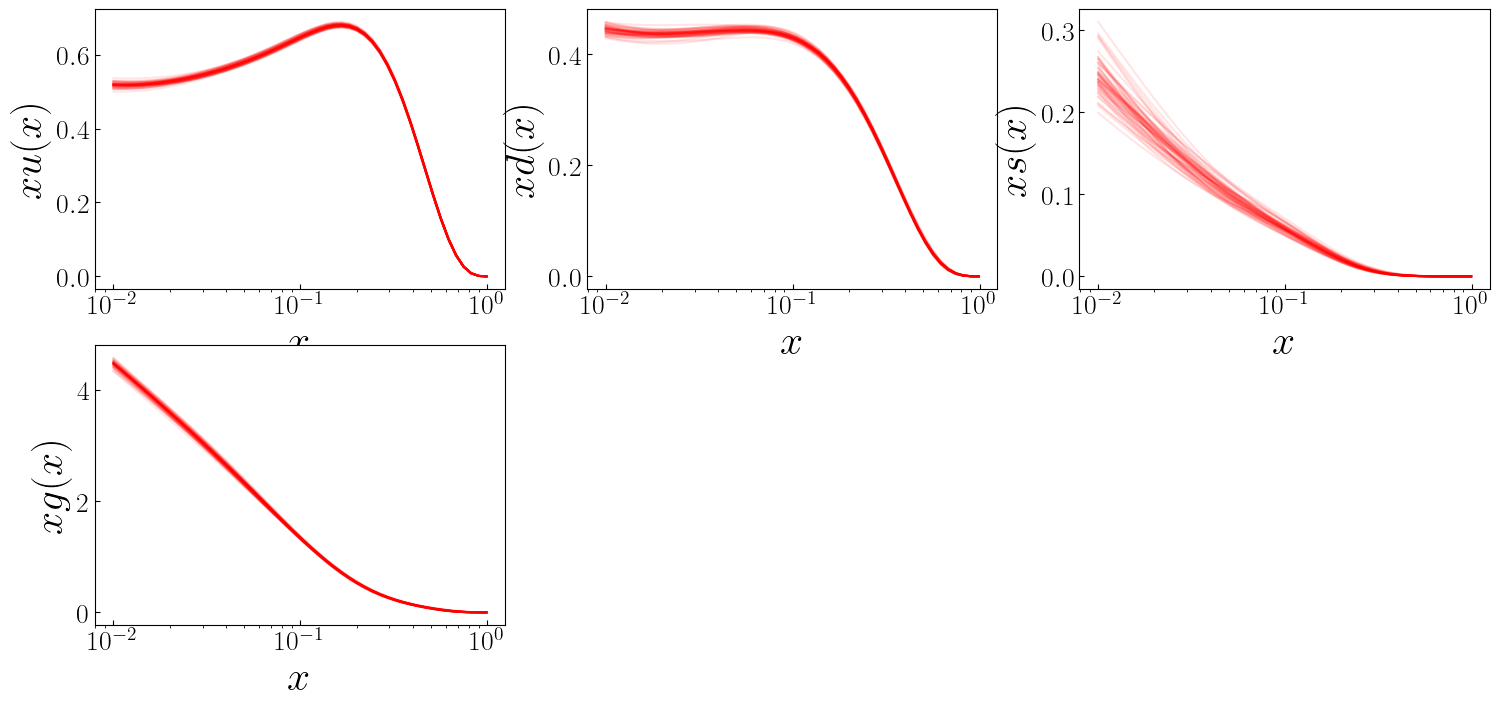

In [44]:
nrows,ncols=2,3; AX={}
fig = py.figure(figsize=(ncols*6,nrows*4))

x=10**np.linspace(-2,np.log10(0.99))
Q2=10

cnt=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(2,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xu(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(1,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xd(x)$',size=30) 

cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(3,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xs(x)$',size=30) 
    
cnt+=1
ax=py.subplot(nrows,ncols,cnt);AX[cnt]=ax
for iset in range(len(pdf[:100])):
    ax.plot(x,[pdf[iset].xfxQ2(21,_,Q2) for _ in x],'r-',alpha=0.1)
    ax.set_ylabel(r'$xg(x)$',size=30) 
    
for _ in AX:    
    ax=AX[_]
    ax.semilogx()
    ax.set_xlabel(r'$x$',size=30)  
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')

In [16]:
def M(x,xg):
    x_ = torch.tensor(x)
    f_ = torch.tensor(xf/x)
    Mtotal = torch.trapz(f_,x_)
    return Mtotal

In [45]:
Ms = []
for i in range(len(pdf)):
    m = [pdf[i].xfxQ2(2,_,Q2)-pdf[i].xfxQ2(1,_,Q2) for _ in x] #computing u-d moment
    Ms.append(M(x,m).cpu().detach().numpy())
Ms = np.array(Ms)
if len(Ms.shape)==1:
    Ms = np.expand_dims(Ms,1)

(array([ 1.,  3.,  4.,  4.,  8., 17., 10.,  4.,  3.,  5.]),
 array([0.74406688, 0.75063816, 0.75720944, 0.76378071, 0.77035199,
        0.77692327, 0.78349454, 0.79006582, 0.7966371 , 0.80320837,
        0.80977965]),
 <BarContainer object of 10 artists>)

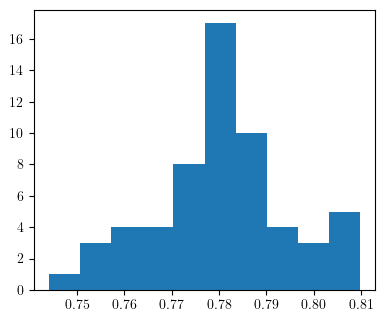

In [46]:
fig = py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1);
ax.hist(Ms,bins=10)

In [47]:
Ms.flatten()

array([0.77986244, 0.78448959, 0.8078307 , 0.80945609, 0.74406688,
       0.80977965, 0.75110519, 0.76891003, 0.78924116, 0.78775456,
       0.77363648, 0.76563519, 0.79358272, 0.76311984, 0.79555693,
       0.77579033, 0.78332468, 0.78058555, 0.77799546, 0.75690647,
       0.80680315, 0.77627594, 0.78497973, 0.78036444, 0.77836624,
       0.77713466, 0.78678024, 0.77943295, 0.78046156, 0.77947338,
       0.7798518 , 0.77393059, 0.78539633, 0.76726325, 0.79429983,
       0.78865497, 0.77391176, 0.80126833, 0.76055969, 0.80277805,
       0.75566016, 0.77774477, 0.78253181, 0.77204672, 0.78558798,
       0.78969366, 0.77413738, 0.80833861, 0.75923979, 0.76475102,
       0.79536997, 0.80109434, 0.75824568, 0.77520976, 0.78460161,
       0.78054982, 0.77989473, 0.7798631 , 0.77986305])

In [49]:
uncert = CT.uncertainty(Ms)

/scratch/slurm/52408565/.cache/tmp/ipykernel_701844/3992942437.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uncert = CT.uncertainty(Ms)


In [50]:
uncert.central

0.7798624352367672

In [51]:
uncert.errplus

0.05054529069654403

In [52]:
uncert.errminus

0.04609370742200225

# Save theory file

In [48]:
n, m = Ms.shape

with open("u-d_moment.theory", "w") as f:
    # First three lines, each with '*'
    f.write("*\n*\n*\n")
    
    # "theory column"
    f.write("Theory column\n")
    
    # m value
    f.write(f"{m}\n")
    
    # Loop over each row
    for i in range(n):
        f.write(f"PDF_{i}_Set\n")
        # Each number: width=12, 6 decimal places, right aligned
        formatted_row = "".join(f"{val:12.6f}" for val in Ms[i])
        f.write(formatted_row + "\n")